### Optimizer Comparison

Author: Tigist Wondimneh & Nahom Senay

ID: GSR/5506/17 and GSR/4848/17

### Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
import pandas
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHES = 10
batch_size = 64
criterion = nn.CrossEntropyLoss()

### Load Dataset From Torch Vision

In [3]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 172kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.22MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.8MB/s]


In [4]:
# 1. Dataset Overview
print(f"Training Samples: {len(train_dataset)}, Test Samples: {len(test_dataset)}")
print(f"Image Shape: {train_dataset[0][0].shape}")

Training Samples: 60000, Test Samples: 10000
Image Shape: torch.Size([1, 28, 28])


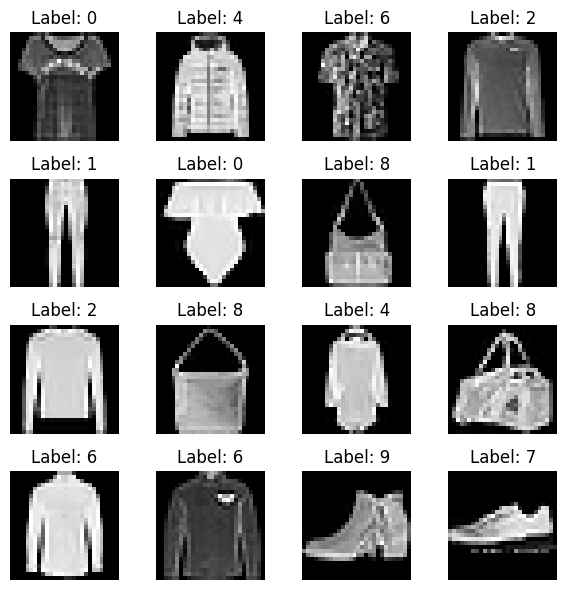

In [5]:
# 2. Visualizing Random MNIST Samples
def plot_samples(dataset, num_samples=16):
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, ax in enumerate(axes.flat):
        img, label = dataset[indices[i]]
        img = img.squeeze().numpy()
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Label: {label}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_samples(train_dataset)

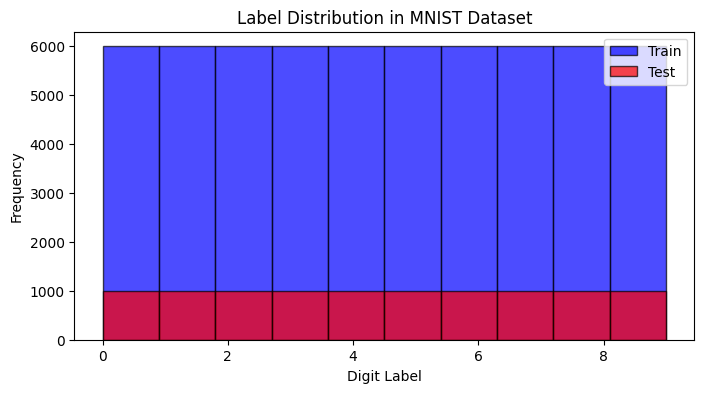

In [6]:
# 3. Distribution of Labels
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]

plt.figure(figsize=(8, 4))
plt.hist(train_labels, bins=10, alpha=0.7, label="Train", color='blue', edgecolor='black')
plt.hist(test_labels, bins=10, alpha=0.7, label="Test", color='red', edgecolor='black')
plt.xlabel("Digit Label")
plt.ylabel("Frequency")
plt.title("Label Distribution in MNIST Dataset")
plt.legend()
plt.show()

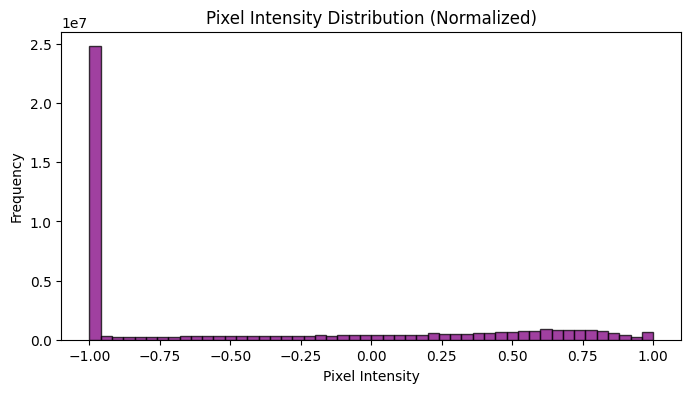

In [7]:
# 4. Pixel Intensity Distribution
train_images = torch.stack([img for img, _ in train_dataset])
pixel_values = train_images.view(-1).numpy()

plt.figure(figsize=(8, 4))
plt.hist(pixel_values, bins=50, color="purple", alpha=0.75, edgecolor="black")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Pixel Intensity Distribution (Normalized)")
plt.show()

### Build A Simple CNN Model

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### Define Optimizers

In [9]:
def get_basic_optimizers(model):
    return {
        # Part-I
        "Batch_Gradient_Descent": torch.optim.SGD(model.parameters(), lr=0.01),
        "Mini_batch_SGD": torch.optim.SGD(model.parameters(), lr=0.01),
        "Stochastic_Gradient_Descent": torch.optim.SGD(model.parameters(), lr=0.01),
    }

In [10]:
def get_advanced_optimizers(model):
    return {
        # # Part-II
        "Gradient_Descent_with_Momentum": torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
        "Gradient_Descent_with_Nesterov_Momentum": torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True),
    }

In [11]:
def get_adaptive_optimizers(model):
    return {
        # Part-III
        "AdaGrad": torch.optim.Adagrad(model.parameters(), lr=0.01),
        "RMSProp": torch.optim.RMSprop(model.parameters(), lr=0.001),
        "Adam": torch.optim.Adam(model.parameters(), lr=0.001)
    }

### Model Training and Evaluation

In [12]:
def train_model(model, optimizer,train_loader, criterion, device, epoch):
    losses = []
    accuracies = []
    avg_gradients = []

    for ep in range(epoch):
        running_loss = 0.0
        correct = 0
        total = 0
        total_grad = 0
        count = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            total_grad += sum(p.grad.abs().mean().item() for p in model.parameters() if p.grad is not None)
            count += 1

            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        losses.append(running_loss / len(train_loader))
        accuracies.append(100 * correct / total)
        avg_gradients.append(total_grad / count)
        print(f"{name} - Epoch {ep+1}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    return losses, accuracies, avg_gradients

In [13]:
from sklearn.metrics import f1_score
def evaluate_model(model, test_loader,device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, F1 Score: {f1:.4f}")
    return avg_val_loss, val_accuracy, f1


### Visualizations

In [28]:
def plot_results(results):
    names = list(results.keys())
    accs = [results[n]["Accuracy"] for n in names]
    f1s = [results[n]["F1 Score"] for n in names]

    x = np.arange(len(names))

    plt.figure(figsize=(10,5))
    plt.bar(x, accs, width=0.3, color='skyblue')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison of Optimizers')
    plt.xticks(x, names, rotation=0, ha="right")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.bar(x, f1s, width=0.3, color='lightgreen')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Comparison of Optimizers')
    plt.xticks(x, names, rotation=0, ha="right")
    plt.tight_layout()
    plt.show()


In [15]:
criterion = nn.CrossEntropyLoss()

### Advanced Optimizers

In [16]:
advanced_optimizers_results = {}
advanced_optimizers_outputs = {}

In [17]:
for name in get_advanced_optimizers(SimpleCNN()).keys():
    print(f"Training with {name}...")
    model = SimpleCNN().to(device)
    optimizer = get_advanced_optimizers(model)[name]
    losses, accuracies, gradients = train_model(model, optimizer, train_loader, criterion, device, EPOCHES)
    loss, acc, f1 = evaluate_model(model, test_loader, device)

    advanced_optimizers_results[name] = {"Loss": loss, "Accuracy": acc, "F1 Score": f1}
    advanced_optimizers_outputs[name] = {"Losses": losses, "Accuracies": accuracies, "Gradients": gradients}

Training with Gradient_Descent_with_Momentum...
Gradient_Descent_with_Momentum - Epoch 1, Loss: 0.5439, Accuracy: 80.44%
Gradient_Descent_with_Momentum - Epoch 2, Loss: 0.3216, Accuracy: 88.31%
Gradient_Descent_with_Momentum - Epoch 3, Loss: 0.2710, Accuracy: 90.14%
Gradient_Descent_with_Momentum - Epoch 4, Loss: 0.2355, Accuracy: 91.31%
Gradient_Descent_with_Momentum - Epoch 5, Loss: 0.2122, Accuracy: 92.13%
Gradient_Descent_with_Momentum - Epoch 6, Loss: 0.1928, Accuracy: 92.86%
Gradient_Descent_with_Momentum - Epoch 7, Loss: 0.1758, Accuracy: 93.58%
Gradient_Descent_with_Momentum - Epoch 8, Loss: 0.1617, Accuracy: 94.02%
Gradient_Descent_with_Momentum - Epoch 9, Loss: 0.1464, Accuracy: 94.57%
Gradient_Descent_with_Momentum - Epoch 10, Loss: 0.1331, Accuracy: 95.17%
Validation Loss: 0.2500, Accuracy: 91.56%, F1 Score: 0.9160
Training with Gradient_Descent_with_Nesterov_Momentum...
Gradient_Descent_with_Nesterov_Momentum - Epoch 1, Loss: 0.5122, Accuracy: 81.54%
Gradient_Descent_with_

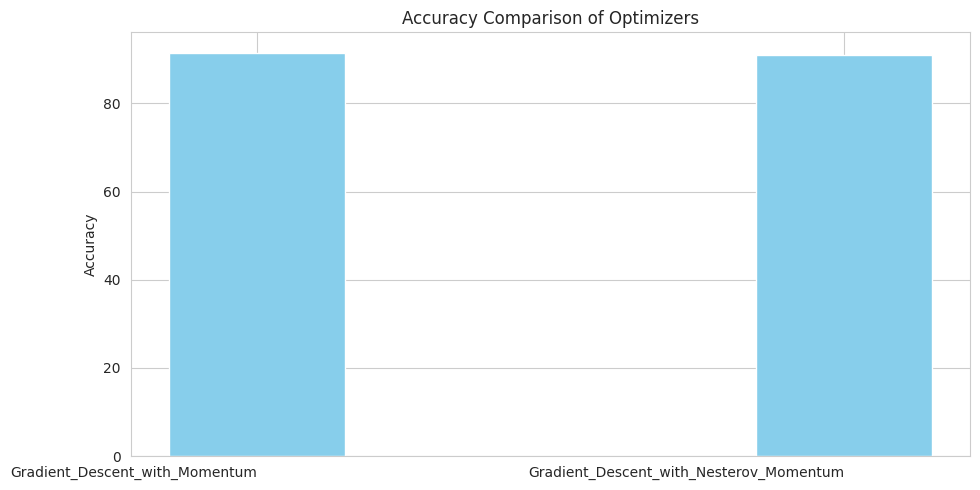

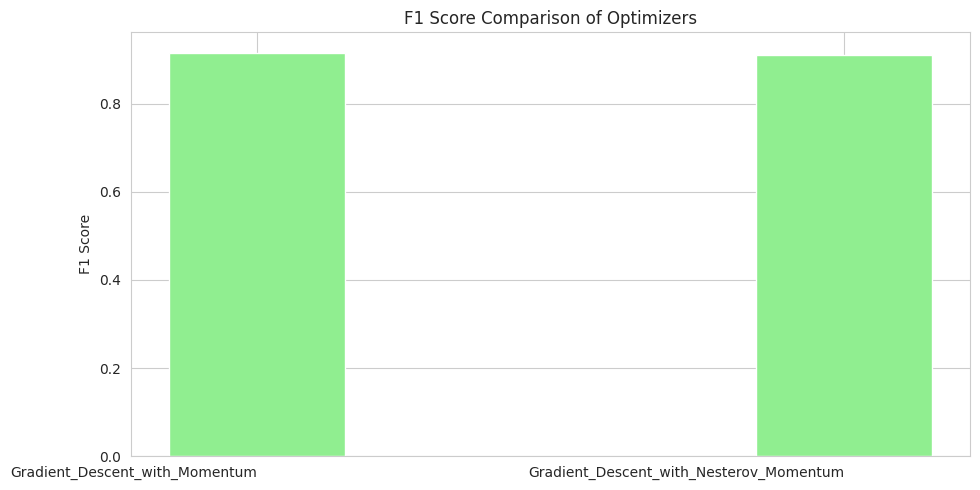

In [40]:
plot_results(advanced_optimizers_results)

In [19]:
# Rankin Basic optimizers
adv_sorted_results = sorted(advanced_optimizers_results.items(), key=lambda x: x[1]['F1 Score'], reverse=True)
print("\nBasic Optimizer Ranking (based on F1 Score):")
for rank, (name, metrics) in enumerate(adv_sorted_results, 1):
    print(f"{rank}. {name} - Accuracy: {metrics['Accuracy']:.4f}, F1 Score: {metrics['F1 Score']:.4f}")



Basic Optimizer Ranking (based on F1 Score):
1. Gradient_Descent_with_Momentum - Accuracy: 91.5600, F1 Score: 0.9160
2. Gradient_Descent_with_Nesterov_Momentum - Accuracy: 91.0500, F1 Score: 0.9101


### Part 2 Optimizer Visualizations

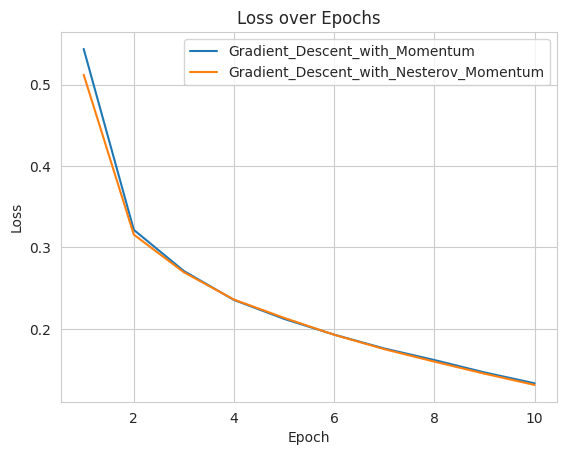

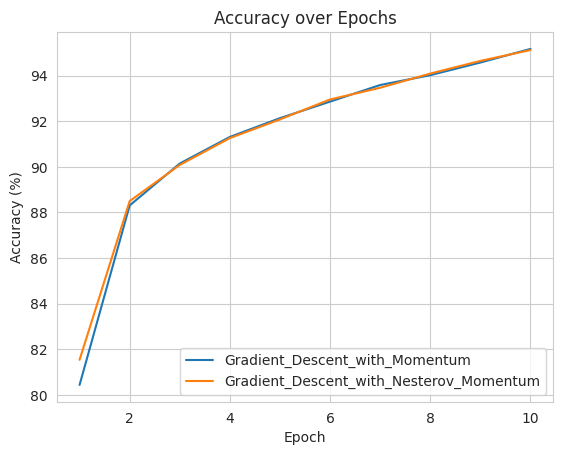

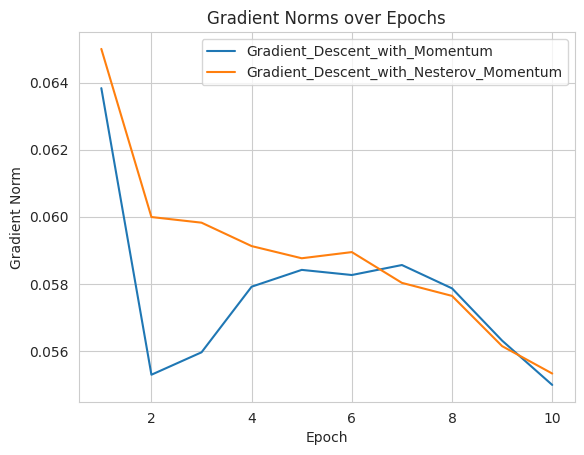

In [39]:
import matplotlib.pyplot as plt

# Data
results = advanced_optimizers_outputs

epochs = list(range(1, 11))

# Plot Loss
plt.figure()
for name, metrics in results.items():
    plt.plot(epochs, metrics['Losses'], label=name)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()

# Plot Accuracy
plt.figure()
for name, metrics in results.items():
    plt.plot(epochs, metrics['Accuracies'], label=name)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png')
plt.show()

# Plot Gradient Norm
plt.figure()
for name, metrics in results.items():
    plt.plot(epochs, metrics['Gradients'], label=name)
plt.title('Gradient Norms over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.legend()
plt.grid(True)
plt.savefig('gradient_plot.png')
plt.show()


### Adaptive OPtimizers

In [20]:
adaptive_optimizers_results = {}
adaptive_optimizers_outputs = {}

In [21]:
for name in get_adaptive_optimizers(SimpleCNN()).keys():
    print(f"Training with {name}...")
    model = SimpleCNN().to(device)
    optimizer = get_adaptive_optimizers(model)[name]
    losses, accuracies, gradients = train_model(model, optimizer, train_loader, criterion, device, EPOCHES)
    loss, acc, f1 = evaluate_model(model, test_loader, device)

    adaptive_optimizers_results[name] = {"Loss": loss, "Accuracy": acc, "F1 Score": f1}
    adaptive_optimizers_outputs[name] = {"Losses": losses, "Accuracies": accuracies, "Gradients": gradients}

Training with AdaGrad...
AdaGrad - Epoch 1, Loss: 0.4539, Accuracy: 83.81%
AdaGrad - Epoch 2, Loss: 0.3107, Accuracy: 88.81%
AdaGrad - Epoch 3, Loss: 0.2777, Accuracy: 90.11%
AdaGrad - Epoch 4, Loss: 0.2581, Accuracy: 90.72%
AdaGrad - Epoch 5, Loss: 0.2420, Accuracy: 91.29%
AdaGrad - Epoch 6, Loss: 0.2305, Accuracy: 91.63%
AdaGrad - Epoch 7, Loss: 0.2205, Accuracy: 92.00%
AdaGrad - Epoch 8, Loss: 0.2115, Accuracy: 92.38%
AdaGrad - Epoch 9, Loss: 0.2038, Accuracy: 92.59%
AdaGrad - Epoch 10, Loss: 0.1961, Accuracy: 92.80%
Validation Loss: 0.2463, Accuracy: 91.15%, F1 Score: 0.9112
Training with RMSProp...
RMSProp - Epoch 1, Loss: 0.4324, Accuracy: 84.38%
RMSProp - Epoch 2, Loss: 0.2733, Accuracy: 90.04%
RMSProp - Epoch 3, Loss: 0.2257, Accuracy: 91.77%
RMSProp - Epoch 4, Loss: 0.1961, Accuracy: 92.81%
RMSProp - Epoch 5, Loss: 0.1713, Accuracy: 93.65%
RMSProp - Epoch 6, Loss: 0.1505, Accuracy: 94.47%
RMSProp - Epoch 7, Loss: 0.1329, Accuracy: 95.03%
RMSProp - Epoch 8, Loss: 0.1150, Accura

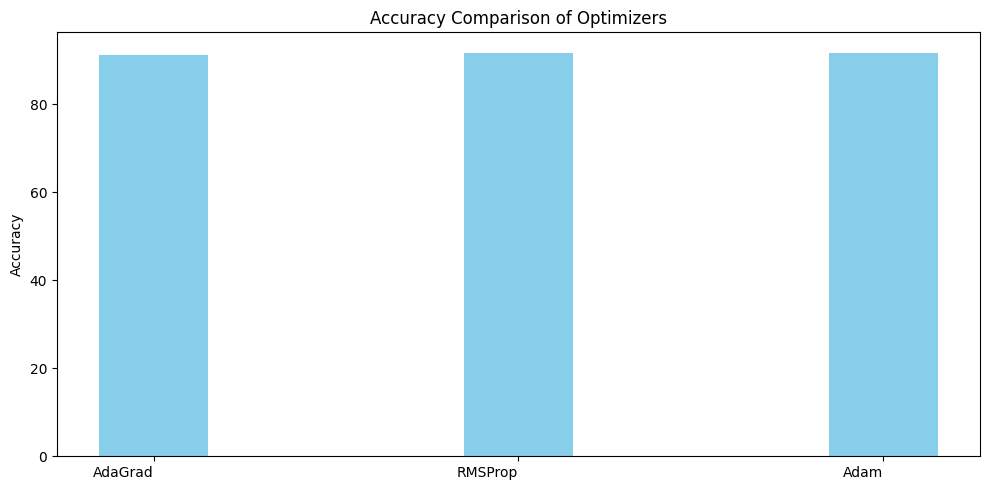

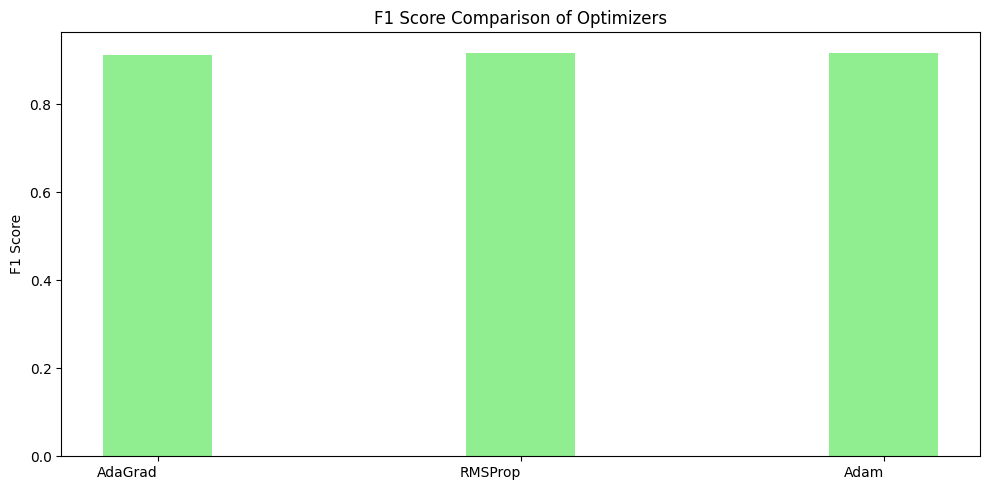

In [30]:
plot_results(adaptive_optimizers_results)

In [23]:
# Rankin Basic optimizers
adap_sorted_results = sorted(adaptive_optimizers_results.items(), key=lambda x: x[1]['F1 Score'], reverse=True)
print("\nBasic Optimizer Ranking (based on F1 Score):")
for rank, (name, metrics) in enumerate(adap_sorted_results, 1):
    print(f"{rank}. {name} - Accuracy: {metrics['Accuracy']:.4f}, F1 Score: {metrics['F1 Score']:.4f}")



Basic Optimizer Ranking (based on F1 Score):
1. Adam - Accuracy: 91.8100, F1 Score: 0.9175
2. RMSProp - Accuracy: 91.7200, F1 Score: 0.9156
3. AdaGrad - Accuracy: 91.1500, F1 Score: 0.9112


### Part 3 Optimizers Visualizations

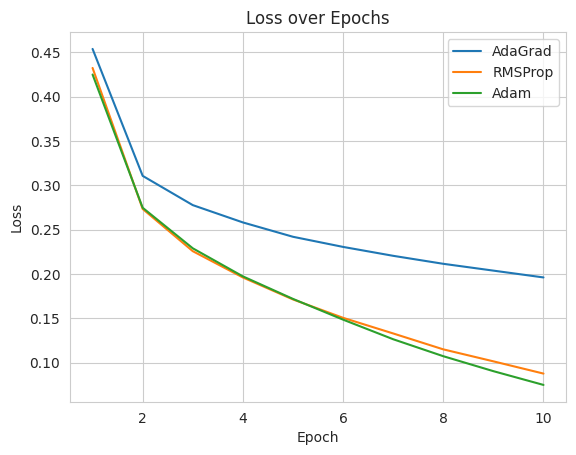

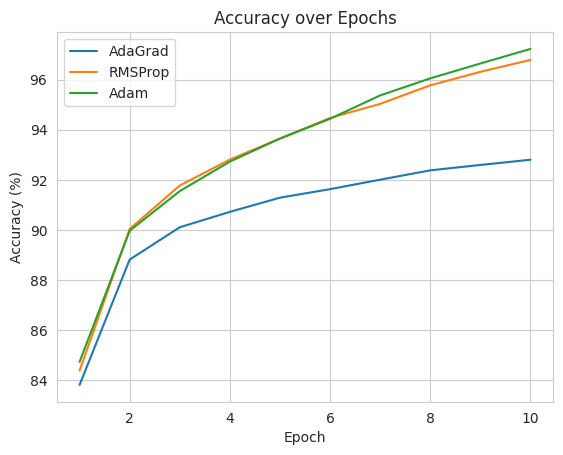

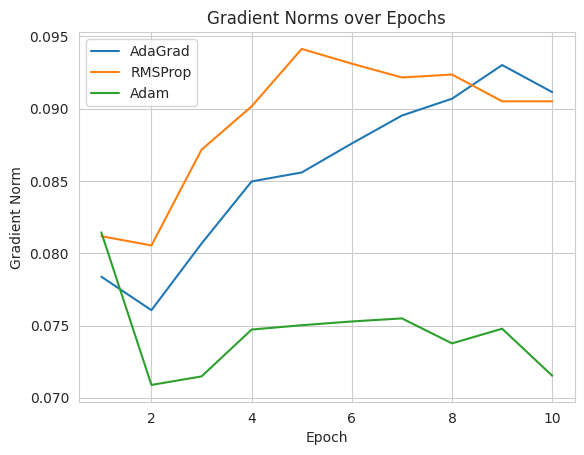

In [38]:
import matplotlib.pyplot as plt

# Data
results = adaptive_optimizers_outputs

epochs = list(range(1, 11))

# Plot Loss
plt.figure()
for name, metrics in results.items():
    plt.plot(epochs, metrics['Losses'], label=name)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()

# Plot Accuracy
plt.figure()
for name, metrics in results.items():
    plt.plot(epochs, metrics['Accuracies'], label=name)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png')
plt.show()

# Plot Gradient Norm
plt.figure()
for name, metrics in results.items():
    plt.plot(epochs, metrics['Gradients'], label=name)
plt.title('Gradient Norms over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.legend()
plt.grid(True)
plt.savefig('gradient_plot.png')
plt.show()


### Comparision between Part 2 and Part 3 optimizers

In [41]:
combined_results = {**advanced_optimizers_outputs, **adaptive_optimizers_outputs}

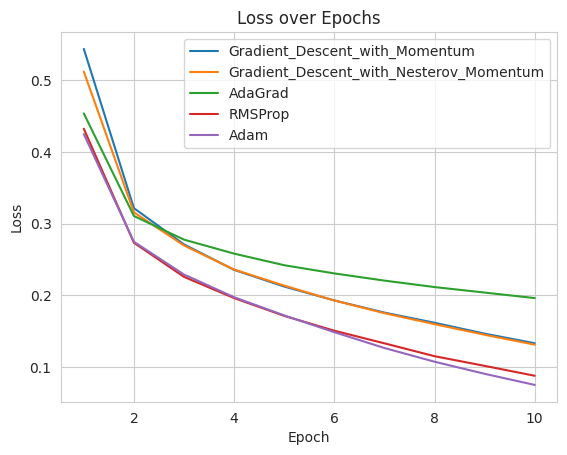

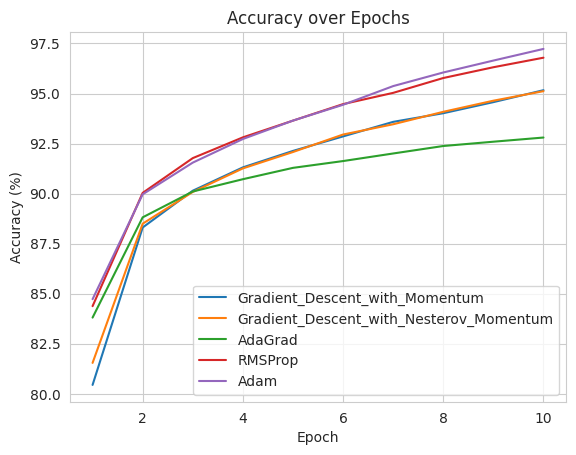

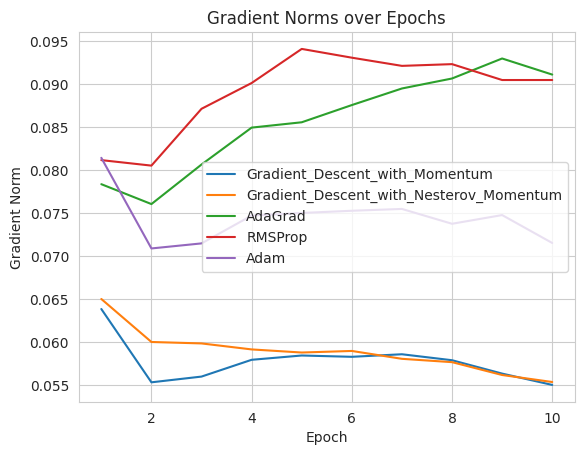

In [42]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))

# Plot Loss
plt.figure()
for name, metrics in combined_results.items():
    plt.plot(epochs, metrics['Losses'], label=name)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure()
for name, metrics in combined_results.items():
    plt.plot(epochs, metrics['Accuracies'], label=name)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Gradient Norms
plt.figure()
for name, metrics in combined_results.items():
    plt.plot(epochs, metrics['Gradients'], label=name)
plt.title('Gradient Norms over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
combined_res = {**advanced_optimizers_results, **adaptive_optimizers_results}

In [46]:
combined_res

{'Gradient_Descent_with_Momentum': {'Loss': 0.2500458658216106,
  'Accuracy': 91.56,
  'F1 Score': 0.916047608779419},
 'Gradient_Descent_with_Nesterov_Momentum': {'Loss': 0.25845272694328786,
  'Accuracy': 91.05,
  'F1 Score': 0.9100721507295151},
 'AdaGrad': {'Loss': 0.24629820043304165,
  'Accuracy': 91.15,
  'F1 Score': 0.9112052008873216},
 'RMSProp': {'Loss': 0.2803488745810879,
  'Accuracy': 91.72,
  'F1 Score': 0.9155817330598338},
 'Adam': {'Loss': 0.2894963563129211,
  'Accuracy': 91.81,
  'F1 Score': 0.9174907333180843}}

In [47]:
# Rankin Basic optimizers
_sorted_results = sorted(combined_res.items(), key=lambda x: x[1]['F1 Score'], reverse=True)
print("\nBasic Optimizer Ranking (based on F1 Score):")
for rank, (name, metrics) in enumerate(_sorted_results, 1):
    print(f"{rank}. {name} - Accuracy: {metrics['Accuracy']:.4f}, F1 Score: {metrics['F1 Score']:.4f}")



Basic Optimizer Ranking (based on F1 Score):
1. Adam - Accuracy: 91.8100, F1 Score: 0.9175
2. Gradient_Descent_with_Momentum - Accuracy: 91.5600, F1 Score: 0.9160
3. RMSProp - Accuracy: 91.7200, F1 Score: 0.9156
4. AdaGrad - Accuracy: 91.1500, F1 Score: 0.9112
5. Gradient_Descent_with_Nesterov_Momentum - Accuracy: 91.0500, F1 Score: 0.9101


In [48]:
# Rankin Basic optimizers
_sorted_results = sorted(combined_res.items(), key=lambda x: x[1]['Accuracy'], reverse=True)
print("\nBasic Optimizer Ranking (based on Accuracy):")
for rank, (name, metrics) in enumerate(_sorted_results, 1):
    print(f"{rank}. {name} - Accuracy: {metrics['Accuracy']:.4f}, F1 Score: {metrics['F1 Score']:.4f}")



Basic Optimizer Ranking (based on Accuracy):
1. Adam - Accuracy: 91.8100, F1 Score: 0.9175
2. RMSProp - Accuracy: 91.7200, F1 Score: 0.9156
3. Gradient_Descent_with_Momentum - Accuracy: 91.5600, F1 Score: 0.9160
4. AdaGrad - Accuracy: 91.1500, F1 Score: 0.9112
5. Gradient_Descent_with_Nesterov_Momentum - Accuracy: 91.0500, F1 Score: 0.9101
